#Custom CNN

In [1]:
!pip install kaggle --quiet

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashrafulhossenakash/alzheimer-disease-dataset
!unzip -q /content/alzheimer-disease-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/ashrafulhossenakash/alzheimer-disease-dataset
License(s): CC0-1.0
 89% 308M/346M [00:01<00:00, 218MB/s]
100% 346M/346M [00:01<00:00, 279MB/s]


In [2]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)


TensorFlow version: 2.19.0
Keras version: 3.10.0


In [4]:
import numpy as np
print(np.__version__)


2.0.2


In [5]:
import sys
print(sys.version)


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [6]:
import tensorflow as tf
import numpy as np
import PIL
import requests
import h5py
import google.protobuf
import scipy
import matplotlib
import sklearn

print("tensorflow==", tf.__version__)
print("numpy==", np.__version__)
print("pillow==", PIL.__version__)
print("requests==", requests.__version__)
print("h5py==", h5py.__version__)
print("protobuf==", google.protobuf.__version__)
print("scipy==", scipy.__version__)
print("matplotlib==", matplotlib.__version__)
print("scikit-learn==", sklearn.__version__)


tensorflow== 2.19.0
numpy== 2.0.2
pillow== 11.3.0
requests== 2.32.3
h5py== 3.14.0
protobuf== 5.29.5
scipy== 1.16.1
matplotlib== 3.10.0
scikit-learn== 1.6.1


In [7]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.5 MB/s eta 0:00:00


In [ ]:
import streamlit as st
print(st.__version__)


1.48.0


In [8]:
train_dir = "/content/Alzheimer_Dataset_V2/train"
val_dir = "/content/Alzheimer_Dataset_V2/val"
test_dir = "/content/Alzheimer_Dataset_V2/test"


In [9]:
image_gen = ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input)


In [10]:
train = image_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val = val_test_gen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test = val_test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

classes = list(train.class_indices.keys())
print("Classes:", classes)


Found 23788 images belonging to 4 classes.
Found 5097 images belonging to 4 classes.
Found 5099 images belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


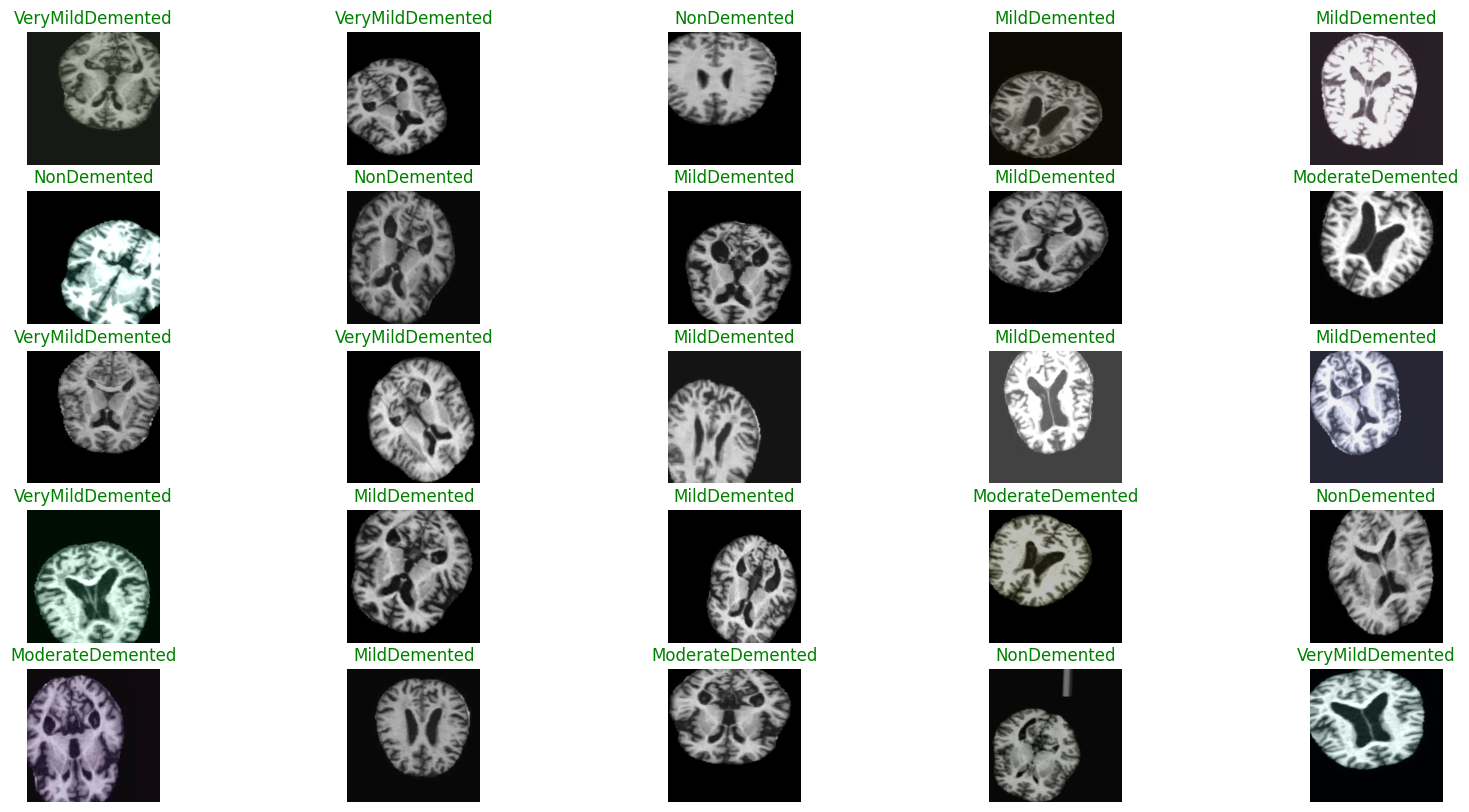

In [11]:
def show_images(image_gen):
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 10))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=12)
        plt.axis('off')
    plt.show()

show_images(train)


In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(224, 224, 3))

x = Conv2D(128, (8, 8), strides=(3, 3), activation='relu', padding='valid', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)

x = Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

x = Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.4)(x)
output_tensor = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 36, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36, 36, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 36, 36, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             

 Total params: 11,350,404 (43.30 MB)

 Trainable params: 11,344,516 (43.28 MB)

 Non-trainable params: 5,888 (23.00 KB)

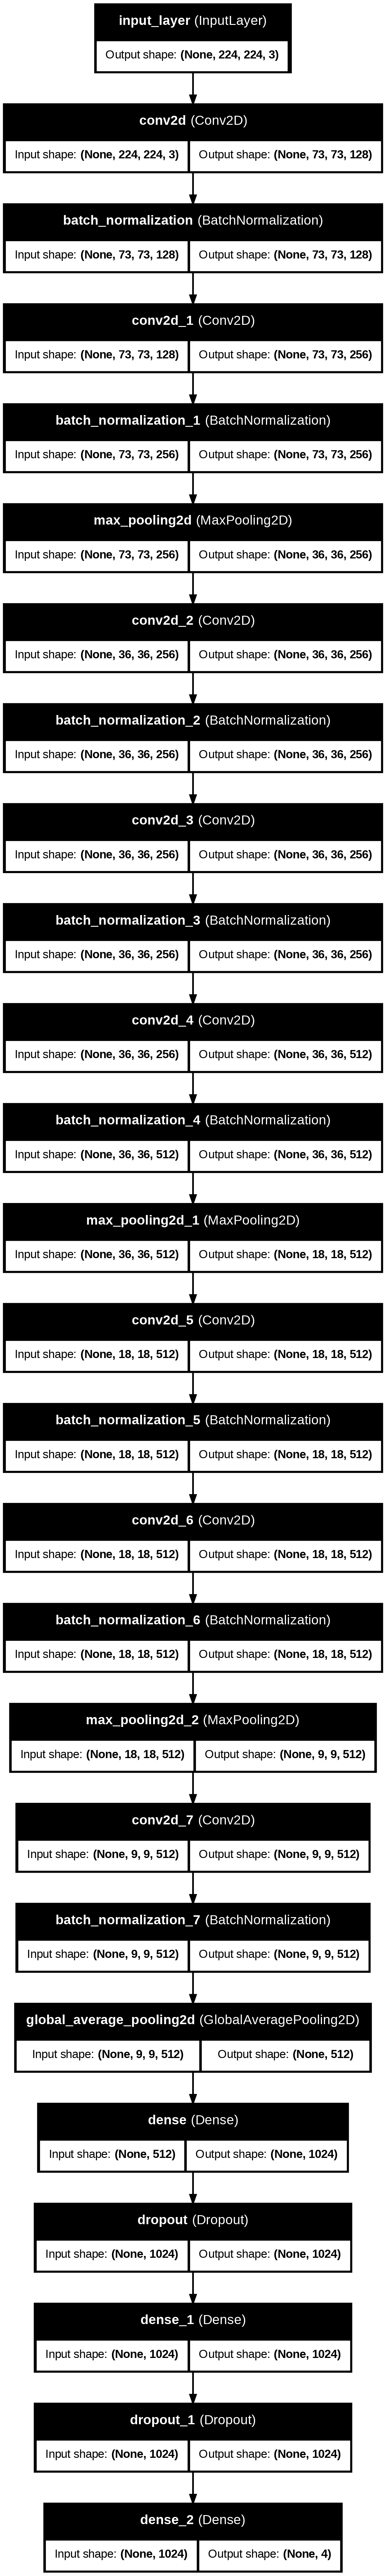

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=callbacks
)


Epoch 1/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.3693 - loss: 1.3344

744/744 ━━━━━━━━━━━━━━━━━━━━ 433s 544ms/step - accuracy: 0.3693 - loss: 1.3343 - val_accuracy: 0.5831 - val_loss: 0.9217 - learning_rate: 1.0000e-04
Epoch 2/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5532 - loss: 0.9568

744/744 ━━━━━━━━━━━━━━━━━━━━ 383s 501ms/step - accuracy: 0.5533 - loss: 0.9567 - val_accuracy: 0.6537 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 3/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6246 - loss: 0.8007

744/744 ━━━━━━━━━━━━━━━━━━━━ 369s 496ms/step - accuracy: 0.6246 - loss: 0.8007 - val_accuracy: 0.6975 - val_loss: 0.6735 - learning_rate: 1.0000e-04
Epoch 4/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 368s 494ms/step - accuracy: 0.6686 - loss: 0.7152 - val_accuracy: 0.6090 - val_loss: 0.8170 - learning_rate: 1.0000e-04
Epoch 5/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7090 - loss: 0.6407

744/744 ━━━━━━━━━━━━━━━━━━━━ 369s 495ms/step - accuracy: 0.7090 - loss: 0.6407 - val_accuracy: 0.7000 - val_loss: 0.7347 - learning_rate: 1.0000e-04
Epoch 6/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7381 - loss: 0.5847

744/744 ━━━━━━━━━━━━━━━━━━━━ 367s 493ms/step - accuracy: 0.7381 - loss: 0.5847 - val_accuracy: 0.7677 - val_loss: 0.4979 - learning_rate: 1.0000e-04
Epoch 7/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7787 - loss: 0.5018

744/744 ━━━━━━━━━━━━━━━━━━━━ 368s 495ms/step - accuracy: 0.7787 - loss: 0.5018 - val_accuracy: 0.8330 - val_loss: 0.3711 - learning_rate: 1.0000e-04
Epoch 8/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8090 - loss: 0.4449

744/744 ━━━━━━━━━━━━━━━━━━━━ 380s 511ms/step - accuracy: 0.8090 - loss: 0.4449 - val_accuracy: 0.8368 - val_loss: 0.4039 - learning_rate: 1.0000e-04
Epoch 9/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8302 - loss: 0.3887

744/744 ━━━━━━━━━━━━━━━━━━━━ 373s 501ms/step - accuracy: 0.8303 - loss: 0.3887 - val_accuracy: 0.8395 - val_loss: 0.3393 - learning_rate: 1.0000e-04
Epoch 10/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8581 - loss: 0.3404

744/744 ━━━━━━━━━━━━━━━━━━━━ 372s 500ms/step - accuracy: 0.8581 - loss: 0.3404 - val_accuracy: 0.8674 - val_loss: 0.3325 - learning_rate: 1.0000e-04
Epoch 11/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8724 - loss: 0.3047

744/744 ━━━━━━━━━━━━━━━━━━━━ 366s 492ms/step - accuracy: 0.8724 - loss: 0.3047 - val_accuracy: 0.9323 - val_loss: 0.1702 - learning_rate: 1.0000e-04
Epoch 12/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8913 - loss: 0.2689

744/744 ━━━━━━━━━━━━━━━━━━━━ 366s 492ms/step - accuracy: 0.8913 - loss: 0.2688 - val_accuracy: 0.9449 - val_loss: 0.1334 - learning_rate: 1.0000e-04
Epoch 13/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 365s 490ms/step - accuracy: 0.9035 - loss: 0.2364 - val_accuracy: 0.8501 - val_loss: 0.3910 - learning_rate: 1.0000e-04
Epoch 14/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9177 - loss: 0.2068

744/744 ━━━━━━━━━━━━━━━━━━━━ 367s 493ms/step - accuracy: 0.9177 - loss: 0.2068 - val_accuracy: 0.9561 - val_loss: 0.1021 - learning_rate: 1.0000e-04
Epoch 15/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 384s 496ms/step - accuracy: 0.9249 - loss: 0.1870 - val_accuracy: 0.7344 - val_loss: 1.2871 - learning_rate: 1.0000e-04
Epoch 16/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9372 - loss: 0.1627

744/744 ━━━━━━━━━━━━━━━━━━━━ 367s 493ms/step - accuracy: 0.9372 - loss: 0.1627 - val_accuracy: 0.9684 - val_loss: 0.0794 - learning_rate: 1.0000e-04
Epoch 17/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9419 - loss: 0.1529

744/744 ━━━━━━━━━━━━━━━━━━━━ 362s 486ms/step - accuracy: 0.9419 - loss: 0.1529 - val_accuracy: 0.9796 - val_loss: 0.0536 - learning_rate: 1.0000e-04
Epoch 18/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 359s 482ms/step - accuracy: 0.9499 - loss: 0.1328 - val_accuracy: 0.9772 - val_loss: 0.0630 - learning_rate: 1.0000e-04
Epoch 19/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9567 - loss: 0.1201

744/744 ━━━━━━━━━━━━━━━━━━━━ 360s 484ms/step - accuracy: 0.9567 - loss: 0.1201 - val_accuracy: 0.9833 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 20/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 367s 493ms/step - accuracy: 0.9558 - loss: 0.1138 - val_accuracy: 0.9531 - val_loss: 0.1236 - learning_rate: 1.0000e-04
Epoch 21/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 362s 487ms/step - accuracy: 0.9560 - loss: 0.1182 - val_accuracy: 0.9810 - val_loss: 0.0502 - learning_rate: 1.0000e-04
Epoch 22/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 364s 489ms/step - accuracy: 0.9631 - loss: 0.0982 - val_accuracy: 0.9825 - val_loss: 0.0490 - learning_rate: 1.0000e-04
Epoch 23/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9722 - loss: 0.0745

744/744 ━━━━━━━━━━━━━━━━━━━━ 360s 484ms/step - accuracy: 0.9722 - loss: 0.0745 - val_accuracy: 0.9965 - val_loss: 0.0106 - learning_rate: 5.0000e-05
Epoch 24/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 360s 484ms/step - accuracy: 0.9819 - loss: 0.0511 - val_accuracy: 0.9951 - val_loss: 0.0141 - learning_rate: 5.0000e-05
Epoch 25/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9817 - loss: 0.0513

744/744 ━━━━━━━━━━━━━━━━━━━━ 363s 487ms/step - accuracy: 0.9817 - loss: 0.0513 - val_accuracy: 0.9978 - val_loss: 0.0062 - learning_rate: 5.0000e-05
Epoch 26/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9829 - loss: 0.0482

744/744 ━━━━━━━━━━━━━━━━━━━━ 393s 502ms/step - accuracy: 0.9829 - loss: 0.0482 - val_accuracy: 0.9980 - val_loss: 0.0051 - learning_rate: 5.0000e-05
Epoch 27/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 364s 489ms/step - accuracy: 0.9826 - loss: 0.0458 - val_accuracy: 0.9976 - val_loss: 0.0068 - learning_rate: 5.0000e-05
Epoch 28/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 362s 487ms/step - accuracy: 0.9823 - loss: 0.0476 - val_accuracy: 0.9963 - val_loss: 0.0125 - learning_rate: 5.0000e-05
Epoch 29/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9843 - loss: 0.0391

744/744 ━━━━━━━━━━━━━━━━━━━━ 364s 489ms/step - accuracy: 0.9843 - loss: 0.0391 - val_accuracy: 0.9982 - val_loss: 0.0062 - learning_rate: 5.0000e-05
Epoch 30/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9871 - loss: 0.0329

744/744 ━━━━━━━━━━━━━━━━━━━━ 364s 490ms/step - accuracy: 0.9871 - loss: 0.0329 - val_accuracy: 0.9994 - val_loss: 0.0033 - learning_rate: 2.5000e-05


In [ ]:
import tensorflow as tf

for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(f"Last Conv2D layer found: {layer.name}")
        break


Last Conv2D layer found: conv2d_7


In [ ]:
model.evaluate(test, verbose=1)
model.save("cnn_gradv2.keras")

160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9993 - loss: 0.0027


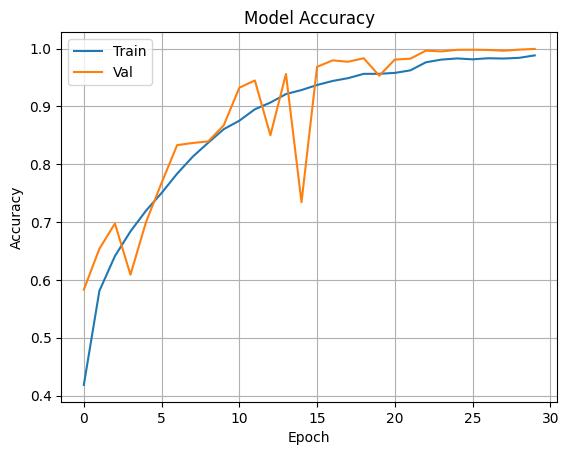

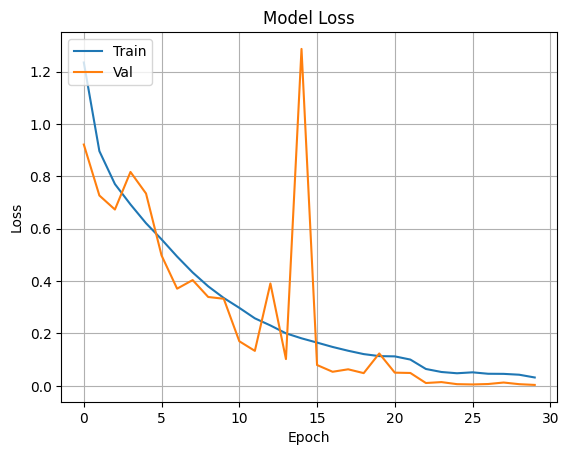

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()


#Classification Report With Confusion Matrix and Inference Time

Found 5099 images belonging to 4 classes.
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step

📊 Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       1.00      1.00      1.00      1440
VeryMildDemented       1.00      1.00      1.00      1344

        accuracy                           1.00      5099
       macro avg       1.00      1.00      1.00      5099
    weighted avg       1.00      1.00      1.00      5099



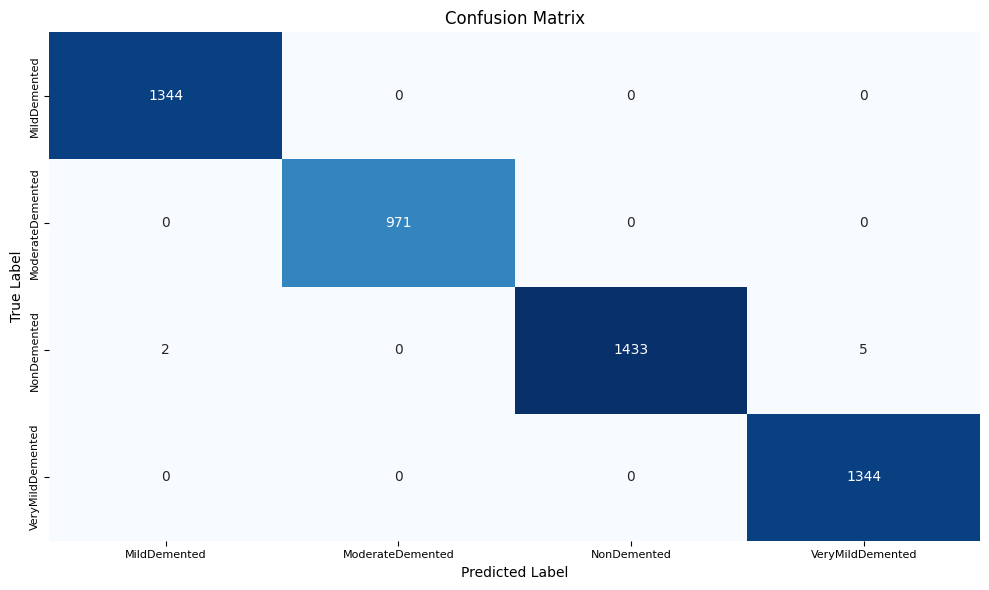

🕒 Total inference time: 17.00 seconds
🕒 Average time per sample: 0.0033 seconds
✅ Accuracy: 99.86%


In [21]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load model
model = load_model("cnn_gradv3.keras")

# Prepare test generator
test_dir = "/content/Alzheimer_Dataset_V2/test"
img_size = (224, 224)
batch_size = 32

test_gen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input)

test = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(test.class_indices.keys())

# Inference time
start = time.time()
pred_probs = model.predict(test, verbose=1)
end = time.time()
inference_time = end - start

# Predictions
y_pred = np.argmax(pred_probs, axis=1)
y_true = test.classes

# Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix with rotated x-axis labels and smaller text
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    annot_kws={"size": 10},
    cbar=False
)

# Center the tick labels
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)
ax.set_xticklabels(class_names, fontsize=8)
ax.set_yticklabels(class_names, fontsize=8, rotation=90)

# Labels & title
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=12)

plt.tight_layout()
plt.show()



# Inference time
print(f"🕒 Total inference time: {inference_time:.2f} seconds")
print(f"🕒 Average time per sample: {inference_time / len(y_true):.4f} seconds")
print(f"✅ Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")


#Grad CAM

Last Conv2D layer: conv2d_7
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


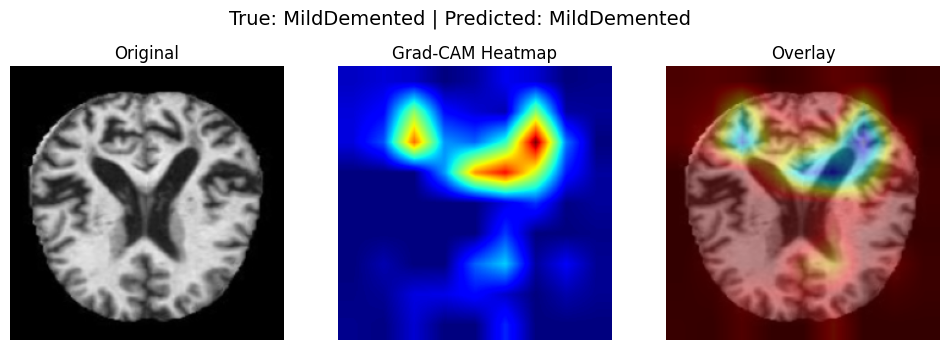

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


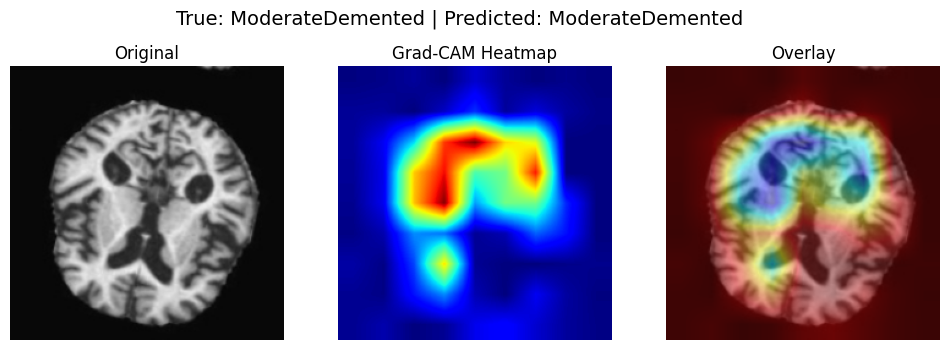

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


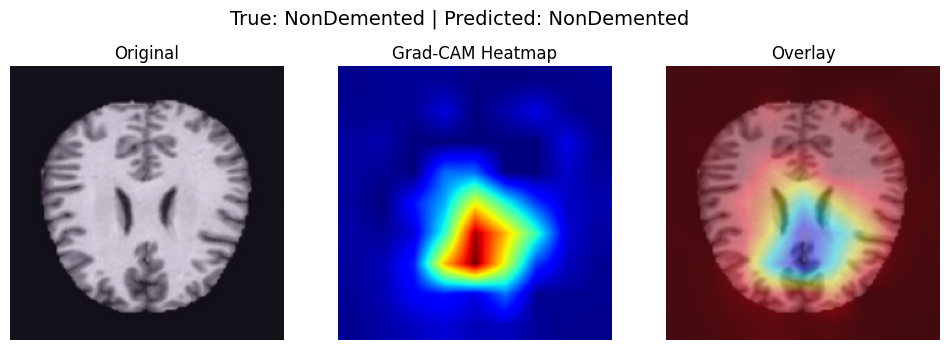

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


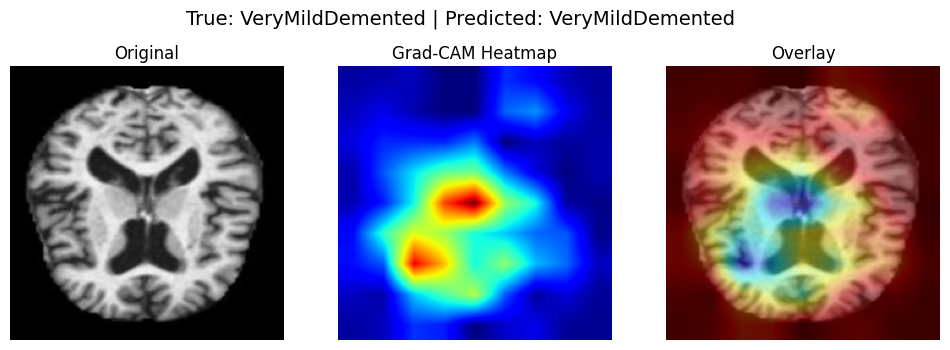

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load model (functional API needed for Grad-CAM)
model = tf.keras.models.load_model("cnn_gradv3.keras")

# Define image size and class names
img_size = (224, 224)
class_names = sorted(os.listdir(test_dir))

# Automatically detect last conv layer name
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print("Last Conv2D layer:", last_conv_layer_name)

# Grad-CAM heatmap function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM visualization
def show_gradcam(img_path, model, class_name):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    pred_label = class_names[pred_class]

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"True: {class_name} | Predicted: {pred_label}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Overlay")
    plt.axis('off')

    plt.show()

# Run for one test image from each class
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    sample_img = os.path.join(class_path, os.listdir(class_path)[0])
    show_gradcam(sample_img, model, class_name)


#Lime Plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━

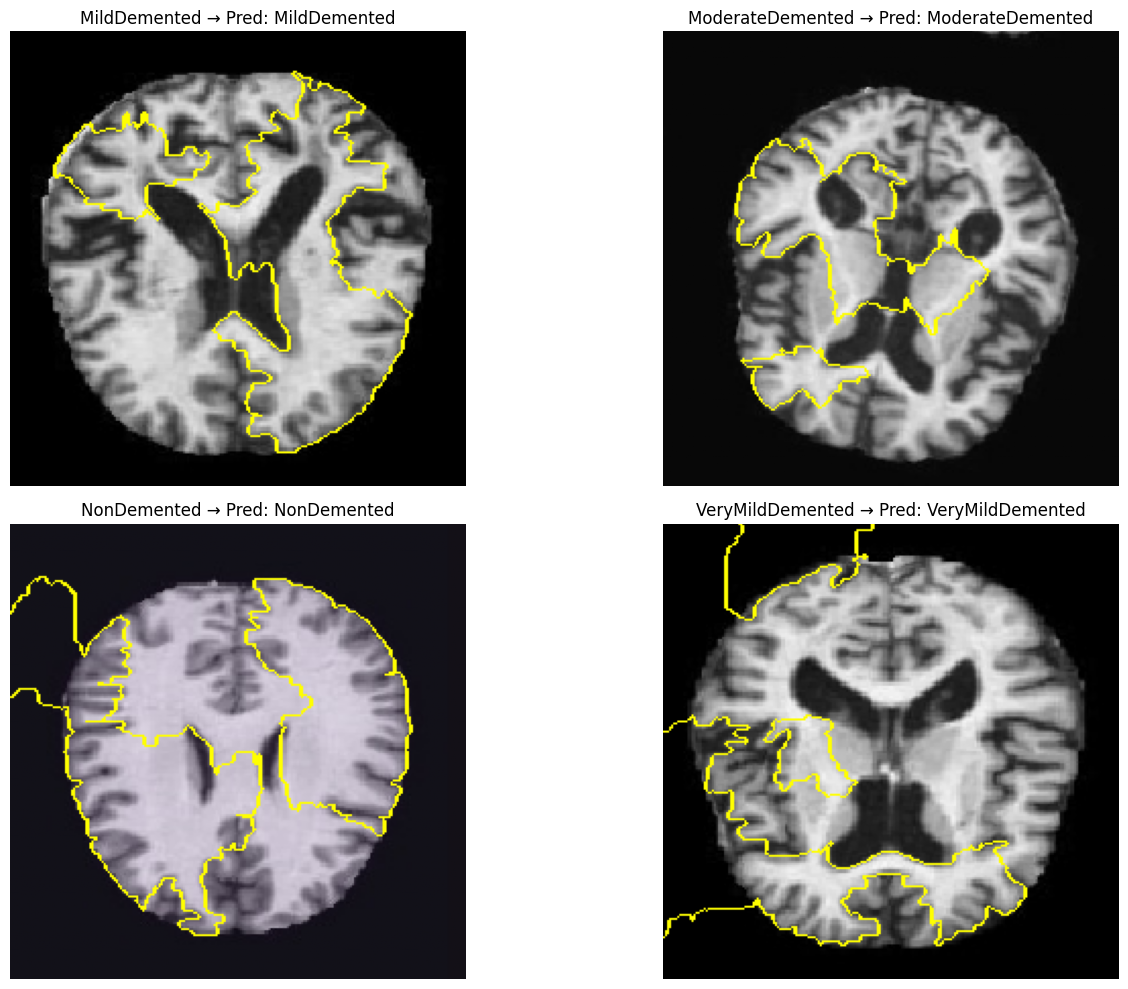

In [22]:
# Install dependencies
!pip install lime scikit-image --quiet

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load the trained model
model = load_model("cnn_gradv3.keras")

# Test directory
test_dir = "/content/Alzheimer_Dataset_V2/test"
class_names = sorted(os.listdir(test_dir))
img_size = (224, 224)

# LIME explainer
explainer = lime_image.LimeImageExplainer()

def load_raw_image(img_path):
    """Load RGB image as uint8 without preprocessing (for LIME visualization)."""
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img).astype(np.uint8)
    return img_array

def predict_fn(images):
    """Prediction function for LIME — preprocess inside."""
    images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
    return model.predict(images)

plt.figure(figsize=(15, 10))

# Loop through each class and explain one sample
for i, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    img_path = os.path.join(class_path, os.listdir(class_path)[0])  # pick first image
    raw_img = load_raw_image(img_path)

    explanation = explainer.explain_instance(
        image=raw_img,
        classifier_fn=predict_fn,
        top_labels=4,
        hide_color=0,
        num_samples=1000
    )

    pred_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label=pred_label,
        positive_only=True,
        hide_rest=False,
        num_features=5,
        min_weight=0.0
    )

    plt.subplot(2, 2, i + 1)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"{class_name} → Pred: {class_names[pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#Integrated Gradients Plot

Loaded test images: (5099, 224, 224, 3)


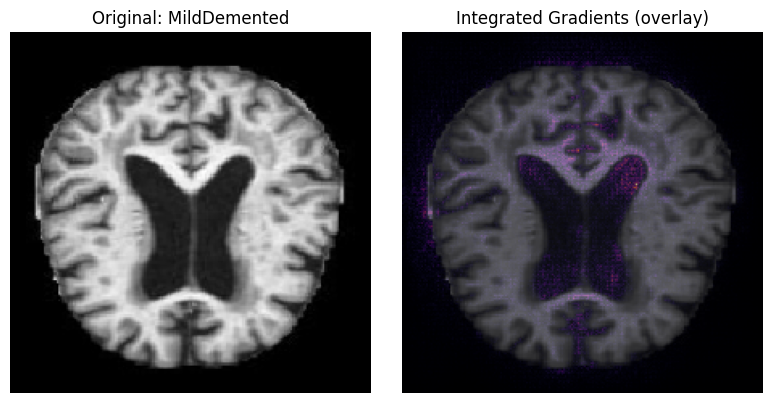

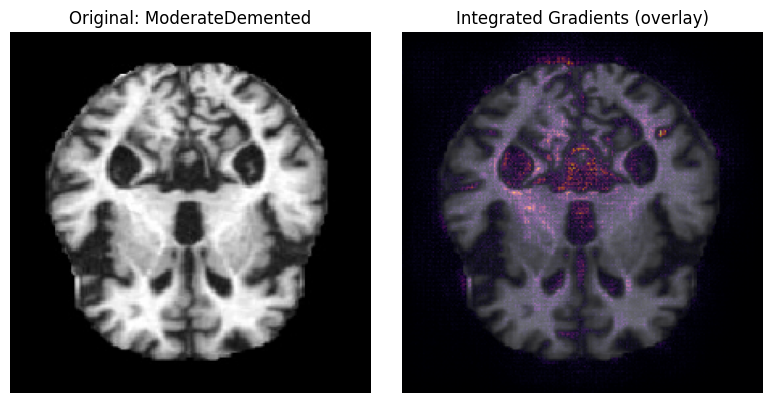

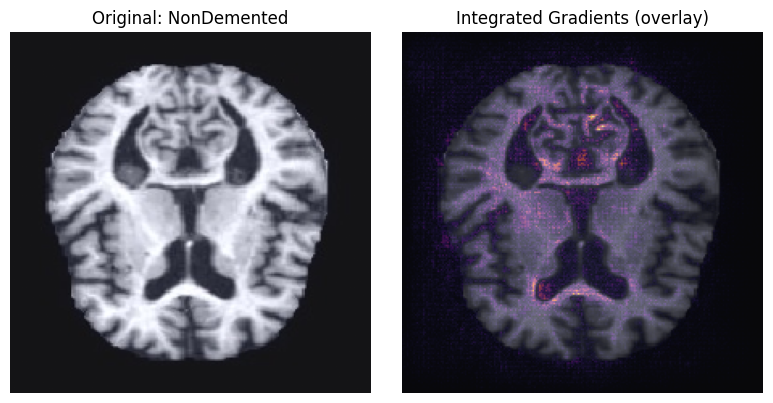

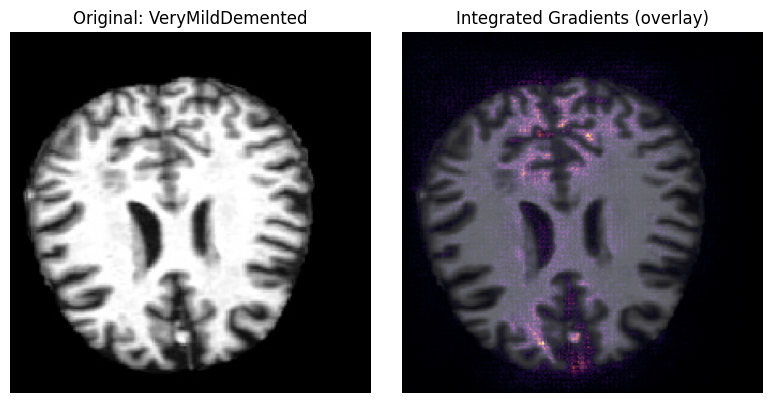

Done. Plotted IG for classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Integrated Gradients helpers (slightly improved) ---
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

def compute_gradients(model, images, target_class_idx):
    # images: [batch, H, W, C]
    images = tf.cast(images, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images, training=False)  # ensure inference mode
        # if model outputs logits/probs, we index the target neuron
        outputs = preds[:, target_class_idx]
    grads = tape.gradient(outputs, images)
    return grads

def integral_approximation(gradients):
    # trapezoid rule
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)
    return avg_grads

def integrated_gradients(model, baseline, image, target_class_idx, m_steps=50):
    """
    image: tf.Tensor shape (H,W,C)
    baseline: tf.Tensor shape (H,W,C)
    returns: integrated grads same shape as image
    """
    # create alphas 0..1 (m_steps+1 points)
    alphas = tf.linspace(0.0, 1.0, num=m_steps + 1)

    # Interpolate images
    interpolated = interpolate_images(baseline, image, alphas)  # shape (m_steps+1, H, W, C)

    # Compute gradients for all interpolated images (batching would be faster)
    grads = []
    for img in interpolated:
        img_batch = tf.expand_dims(img, axis=0)
        g = compute_gradients(model, img_batch, target_class_idx)  # shape (1,H,W,C)
        grads.append(g[0])
    grads = tf.stack(grads)  # shape (m_steps+1, H, W, C)

    avg_grads = integral_approximation(grads)  # shape (H,W,C)
    integrated_grads = (image - baseline) * avg_grads
    return integrated_grads

# --- visualization helper ---
def plot_integrated_gradients(img, attributions, class_name, cmap='inferno'):
    # img assumed preprocessed with mobilenet_v2.preprocess_input => in [-1,1]
    # convert to displayable image:
    display_img = (img + 1.0) / 2.0
    display_img = np.clip(display_img, 0.0, 1.0)

    # aggregate attributions across channels
    atts = np.sum(np.abs(attributions), axis=-1)
    atts = (atts - atts.min()) / (atts.max() - atts.min() + 1e-8)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(display_img)
    ax[0].set_title(f"Original: {class_name}")
    ax[0].axis('off')

    ax[1].imshow(display_img)
    ax[1].imshow(atts, cmap=cmap, alpha=0.6)  # overlay
    ax[1].set_title("Integrated Gradients (overlay)")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

# ------------------------------
# Materialize test generator into arrays
# ------------------------------
X_test_list = []
y_test_list = []
n_batches = len(test)  # test is a Sequence, supports len()

for i in range(n_batches):
    Xb, yb = test[i]         # safe: Sequence indexing
    X_test_list.append(Xb)
    y_test_list.append(yb)

X_test = np.vstack(X_test_list)    # shape (N, H, W, C)
y_test = np.vstack(y_test_list)    # shape (N, num_classes)
y_labels = np.argmax(y_test, axis=1)  # shape (N,)

print("Loaded test images:", X_test.shape)

# ------------------------------
# For each class, pick 1 sample and compute IG
# ------------------------------
baseline = np.zeros((224, 224, 3), dtype=np.float32)  # black baseline in preprocess space
m_steps = 50  # increase for more accurate IG; reduce for speed

num_classes = len(classes)  # should be 4
found_classes = []

for class_idx, class_name in enumerate(classes):
    idxs = np.where(y_labels == class_idx)[0]
    if len(idxs) == 0:
        print(f"Warning: no samples of class {class_name} in test set. Skipping.")
        continue

    idx = idxs[0]  # first sample of that class
    img = X_test[idx]           # shape (H,W,C), already preprocessed
    # run IG
    atts = integrated_gradients(
        model,
        baseline=tf.constant(baseline, dtype=tf.float32),
        image=tf.constant(img, dtype=tf.float32),
        target_class_idx=class_idx,
        m_steps=m_steps
    )
    plot_integrated_gradients(img, atts.numpy(), class_name)
    found_classes.append(class_name)

print("Done. Plotted IG for classes:", found_classes)


#Guided Grad-cam Overlay Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


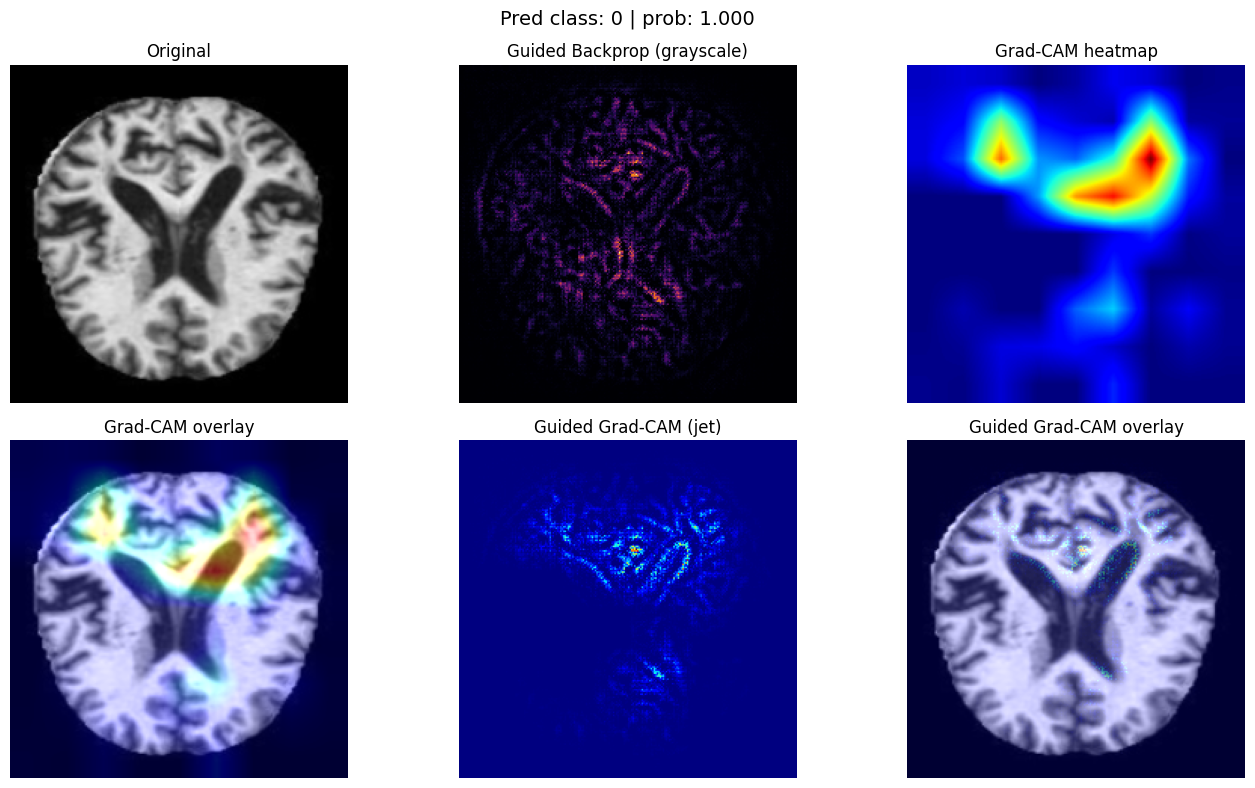

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


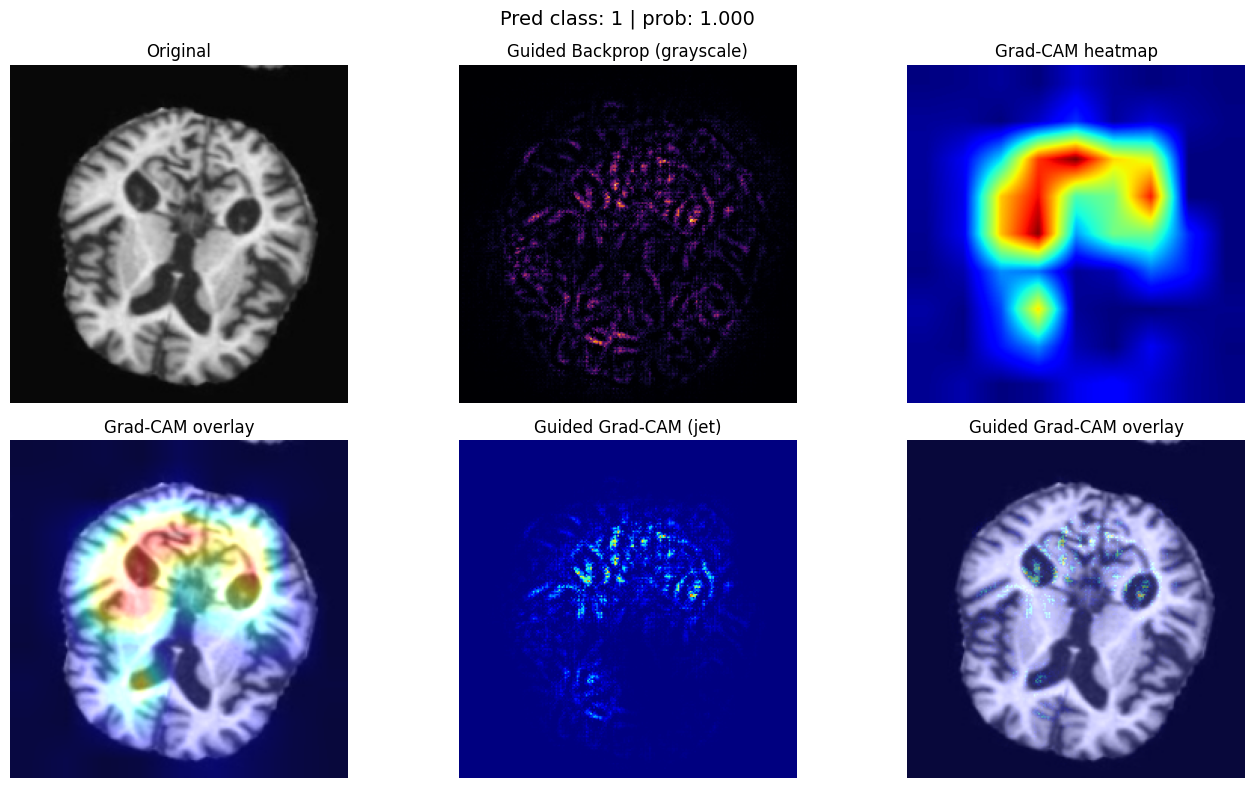

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


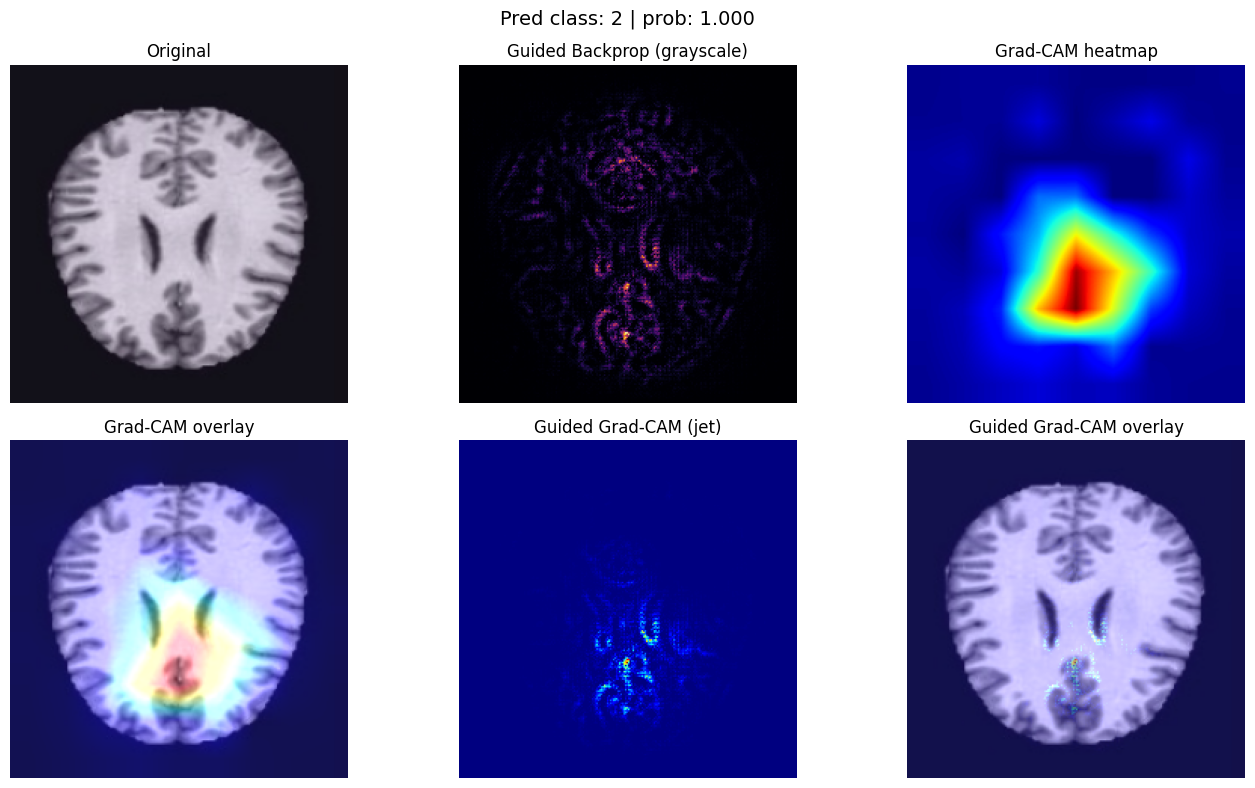

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


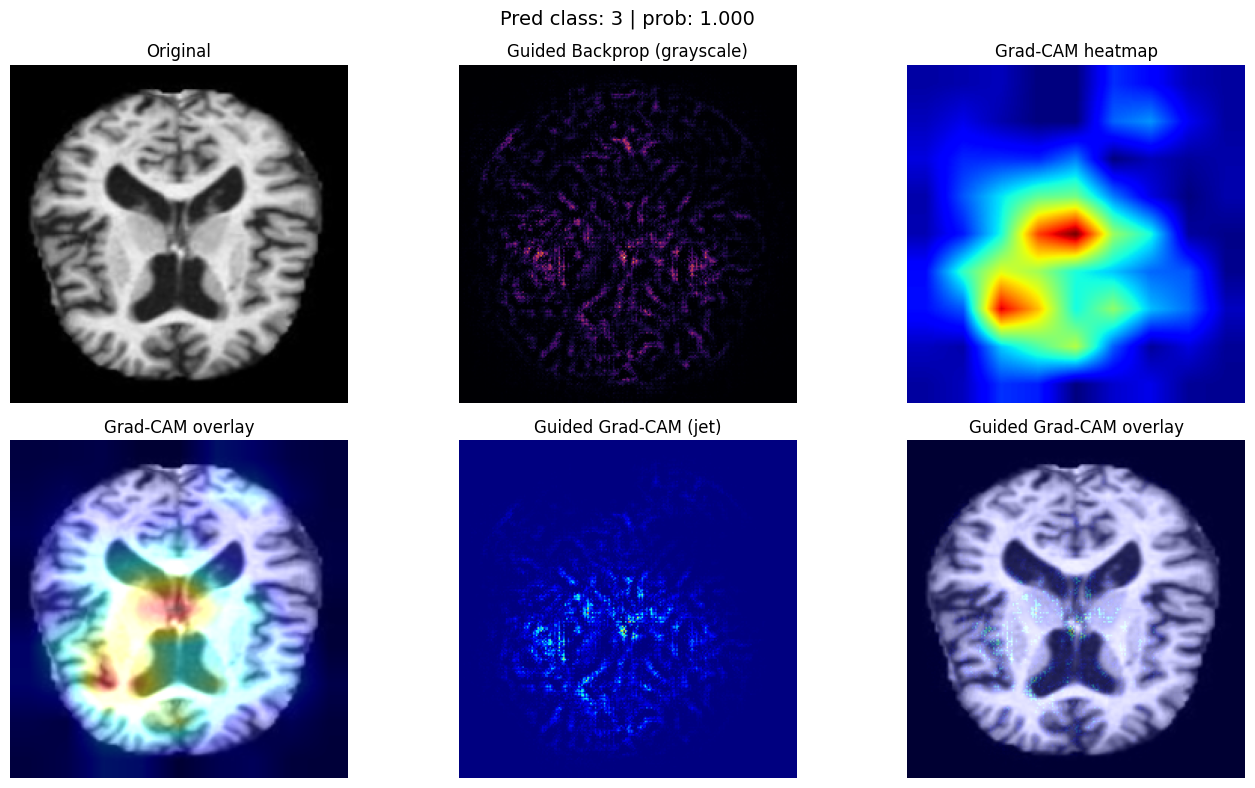

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def compute_guided_backprop(model, img_array, pred_index):
    """
    Compute gradients of the class score w.r.t. input image (vanilla backprop),
    then convert to "guided" by zeroing negative gradients.
    img_array: preprocessed input with shape (1,H,W,C)
    returns: guided_grads (H,W,C) normalized to [-1,1] (float32)
    """
    img_tensor = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor, training=False)
        loss = preds[:, pred_index]

    grads = tape.gradient(loss, img_tensor)[0].numpy()  # (H,W,C)

    # Guided approximation: zero-out negative gradients
    guided_grads = np.maximum(grads, 0.0)

    # Normalize per-image for display
    denom = np.max(np.abs(guided_grads)) + 1e-8
    guided_grads = guided_grads / denom
    return guided_grads

def guided_gradcam_overlay(img_path, model, last_conv_layer_name, alpha=0.4):
    """
    For a single image path: compute Grad-CAM, guided backprop, combine,
    and display original / guided backprop / gradcam overlay / guided-gradcam.
    """
    # load & preprocess (same as your show_gradcam)
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    preimg = tf.keras.applications.mobilenet_v2.preprocess_input(img_array.copy())
    preimg_batch = np.expand_dims(preimg, axis=0)

    # preds
    preds = model.predict(preimg_batch)
    pred_class = np.argmax(preds[0])

    # Grad-CAM heatmap (H_conv, W_conv) normalized 0..1
    heatmap = make_gradcam_heatmap(preimg_batch, model, last_conv_layer_name, pred_index=pred_class)
    heatmap_resized = cv2.resize(heatmap, (img_size[1], img_size[0]))  # width, height

    # Guided backprop (H,W,C) in [-1..1] approximately
    guided_grads = compute_guided_backprop(model, preimg_batch, pred_class)  # shape (H,W,C)

    # Guided Grad-CAM: weight guided gradients by the heatmap (channel-wise)
    # expand heatmap to channels shape
    heatmap_expanded = np.expand_dims(heatmap_resized, axis=-1)  # (H,W,1)
    guided_gradcam = guided_grads * heatmap_expanded  # (H,W,C)

    # Aggregate channels for visualization
    guided_grads_gray = np.sum(np.abs(guided_grads), axis=-1)
    guided_gradcam_gray = np.sum(np.abs(guided_gradcam), axis=-1)

    # Normalize for display
    def normalize(x):
        x = x - np.min(x)
        if np.max(x) > 0:
            x = x / np.max(x)
        return x

    guided_grads_gray = normalize(guided_grads_gray)
    guided_gradcam_gray = normalize(guided_gradcam_gray)
    heatmap_vis = normalize(heatmap_resized)

    # Read original image (RGB)
    orig = cv2.imread(img_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, (img_size[1], img_size[0]))

    # Make color overlays
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_vis), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay_gradcam = cv2.addWeighted(orig.astype(np.float32)/255.0, 1.0, heatmap_color.astype(np.float32)/255.0, alpha, 0)

    # Guided-gradcam overlay: show guided_gradcam_gray as jet and overlay
    guided_jet = cv2.applyColorMap(np.uint8(255 * guided_gradcam_gray), cv2.COLORMAP_JET)
    guided_jet = cv2.cvtColor(guided_jet, cv2.COLOR_BGR2RGB)
    overlay_guided = cv2.addWeighted(orig.astype(np.float32)/255.0, 1.0, guided_jet.astype(np.float32)/255.0, alpha, 0)

    # Plot results
    plt.figure(figsize=(14, 8))
    plt.suptitle(f"Pred class: {pred_class} | prob: {preds[0][pred_class]:.3f}", fontsize=14)

    plt.subplot(2, 3, 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(guided_grads_gray, cmap='inferno')
    plt.title("Guided Backprop (grayscale)")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(heatmap_vis, cmap='jet')
    plt.title("Grad-CAM heatmap")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(overlay_gradcam)
    plt.title("Grad-CAM overlay")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(guided_jet)
    plt.title("Guided Grad-CAM (jet)")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(overlay_guided)
    plt.title("Guided Grad-CAM overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: run for first image of each class in test_dir
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    sample_img = os.path.join(class_path, os.listdir(class_path)[0])
    guided_gradcam_overlay(sample_img, model, last_conv_layer_name)


#ROC plot

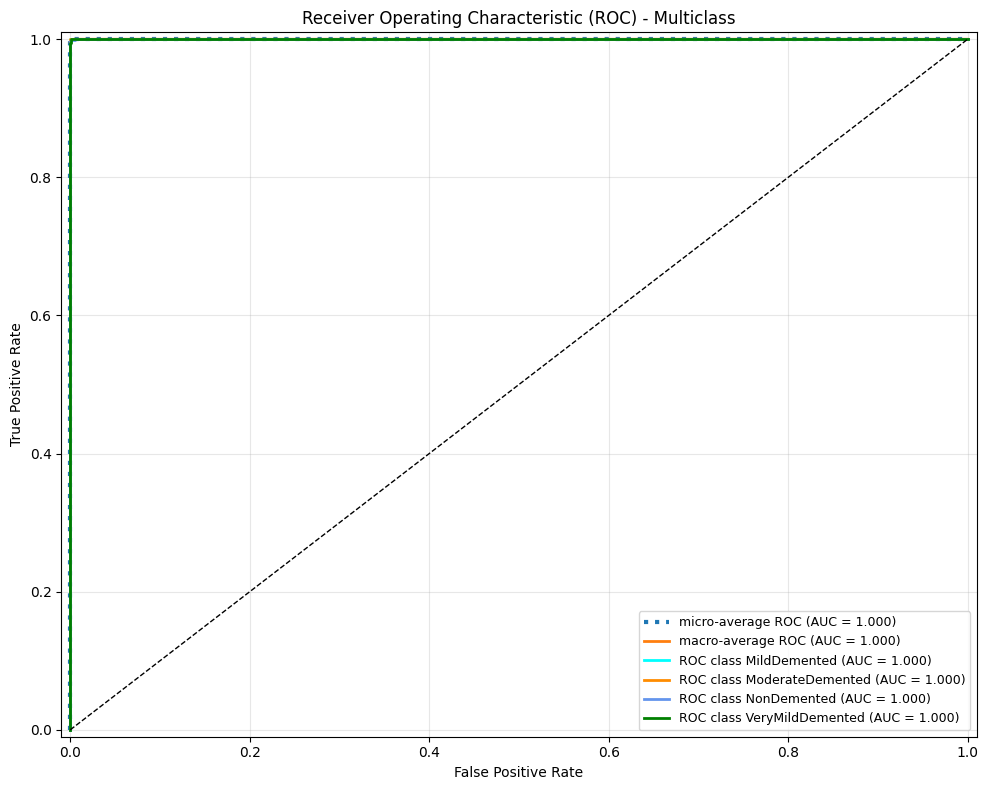

AUC per class:
  MildDemented: 1.0000
  ModerateDemented: 1.0000
  NonDemented: 1.0000
  VeryMildDemented: 1.0000
micro-average AUC: 1.0000
macro-average AUC: 1.0000


In [26]:
# Requires: sklearn, matplotlib, numpy (you already have these)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- prepare variables (use your existing pred_probs and y_true) ---
# pred_probs: shape (N, num_classes), probabilities output by model.predict(test)
# y_true: shape (N,), integer class labels (e.g., test.classes)
# class_names: list of class names in the same order as model outputs

y_true = np.asarray(y_true).astype(int)           # ensure integer array
y_score = np.asarray(pred_probs)                  # (N, C)
n_classes = len(class_names)

# Binarize the output
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))  # shape (N, C)

# --- compute ROC curve and AUC for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC (all classes flattened)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC (aggregate all FPR points, then average TPR)
# First get all unique FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points and average
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plotting ---
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=3)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         linestyle='-', linewidth=2)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC class {class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # diagonal
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save high-resolution figure for paper
plt.savefig("roc_multiclass.png", dpi=300)
plt.show()

# --- Print AUC summary ---
print("AUC per class:")
for i in range(n_classes):
    print(f"  {class_names[i]}: {roc_auc[i]:.4f}")
print(f"micro-average AUC: {roc_auc['micro']:.4f}")
print(f"macro-average AUC: {roc_auc['macro']:.4f}")


#ROC Plot 2

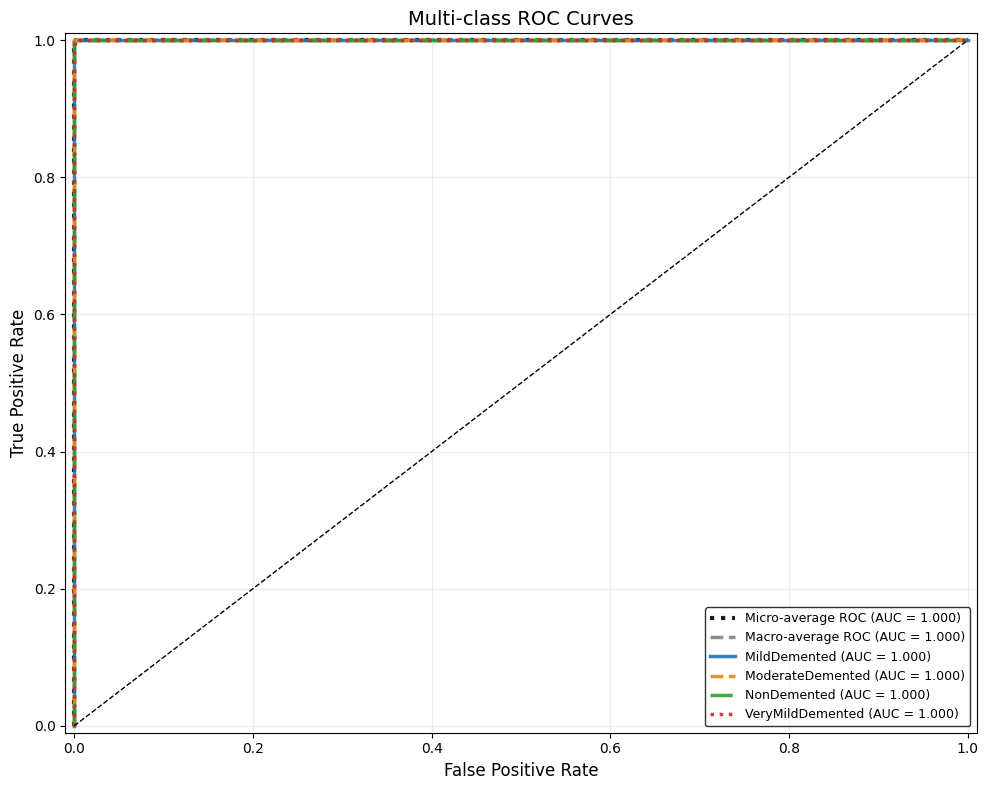

AUC summary:
  MildDemented: 1.0000
  ModerateDemented: 1.0000
  NonDemented: 1.0000
  VeryMildDemented: 1.0000
Micro-average AUC: 1.0000
Macro-average AUC: 1.0000


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# -------------------------
# INPUT: provide these
# -------------------------
# pred_probs : numpy array shape (N, C) - model probabilities (or logits)
# y_true     : numpy array shape (N,)    - integer labels 0..C-1 (e.g., test.classes)
# class_names: list of length C          - class names in model-output order

# Example placeholders (uncomment & replace with your actual variables if needed):
# pred_probs = model.predict(test)    # <-- if you want to compute from your model
# y_true = np.asarray(test.classes)
# class_names = list(test.class_indices.keys())

# ---- sanity check / safety ----
y_true = np.asarray(y_true).astype(int)
y_score = np.asarray(pred_probs)
if y_score.ndim == 1:
    # if shape (N,), convert to (N,1)
    y_score = y_score.reshape(-1, 1)

n_samples, n_classes = y_score.shape
assert n_samples == y_true.shape[0], "pred_probs and y_true must have same number of samples"

# If predictions are logits (not probabilities), convert with softmax
row_sums = np.sum(y_score, axis=1)
if (np.any(y_score < 0) or np.any(row_sums <= 0) or not np.allclose(row_sums, 1.0, atol=1e-3)):
    # apply stable softmax
    logits = y_score
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    y_score = exps / np.sum(exps, axis=1, keepdims=True)

# Binarize true labels for one-vs-rest ROC
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC and AUC for each class
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# -------------------------
# PLOTTING
# -------------------------
plt.figure(figsize=(10, 8), facecolor='white')

# Distinct colormap depending on number of classes
if n_classes <= 10:
    cmap = plt.get_cmap("tab10")
else:
    cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(n_classes)]

# Plot micro and macro
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='black', linestyle=':', linewidth=3, alpha=0.9)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         color='gray', linestyle='--', linewidth=2.5, alpha=0.9)

# Plot each class ROC
linestyles = ['-', '--', '-.', ':'] * 10
for i in range(n_classes):
    lbl = class_names[i] if i < len(class_names) else f"Class {i}"
    plt.plot(fpr[i], tpr[i],
             color=colors[i],
             lw=2.5,
             linestyle=linestyles[i],
             alpha=0.9,
             label=f'{lbl} (AUC = {roc_auc[i]:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curves', fontsize=14)

# Legend: place outside if too crowded
plt.legend(loc='lower right', fontsize=9, frameon=True, edgecolor='k')
plt.grid(alpha=0.25)
plt.tight_layout()

# Save high-res figure
plt.savefig("roc_multiclass.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# -------------------------
# PRINT AUC SUMMARY
# -------------------------
print("AUC summary:")
for i in range(n_classes):
    lbl = class_names[i] if i < len(class_names) else f"Class {i}"
    print(f"  {lbl}: {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


#Accuracy, Precision, Recall, AUC, F1-Score for every class

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# ---- Get predictions from your model ----
y_true = test.classes  # True labels
class_names = list(test.class_indices.keys())

# Predict probabilities
y_pred_probs = model.predict(test)  # shape (N, C)
y_pred = np.argmax(y_pred_probs, axis=1)

n_classes = len(class_names)

# Binarize labels for AUC
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# ---- Metrics per class ----
results = []
for i in range(n_classes):
    acc = accuracy_score(y_true == i, y_pred == i)
    prec = precision_score(y_true, y_pred, labels=[i], average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, labels=[i], average='macro', zero_division=0)
    auc = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])
    results.append([class_names[i], acc, prec, rec, f1, auc])

# ---- Macro & Micro averages ----
acc_macro = accuracy_score(y_true, y_pred)
prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
auc_macro = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')

prec_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
rec_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
auc_micro = roc_auc_score(y_true_bin, y_pred_probs, average='micro', multi_class='ovr')

results.append(["Macro Avg", acc_macro, prec_macro, rec_macro, f1_macro, auc_macro])
results.append(["Micro Avg", acc_macro, prec_micro, rec_micro, f1_micro, auc_micro])

# ---- Create table ----
df_metrics = pd.DataFrame(results, columns=["Class", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"])
df_metrics = df_metrics.round(4)

print(df_metrics)


160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step
              Class  Accuracy  Precision  Recall  F1-Score  AUC
0      MildDemented    0.9996     0.9985  1.0000    0.9993  1.0
1  ModerateDemented    1.0000     1.0000  1.0000    1.0000  1.0
2       NonDemented    0.9986     1.0000  0.9951    0.9976  1.0
3  VeryMildDemented    0.9990     0.9963  1.0000    0.9981  1.0
4         Macro Avg    0.9986     0.9987  0.9988    0.9987  1.0
5         Micro Avg    0.9986     0.9986  0.9986    0.9986  1.0


##Accuracy, Precision, Recall, AUC, F1-Score for model

In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# True labels and predictions
y_true = test.classes
y_pred_probs = model.predict(test)
y_pred = np.argmax(y_pred_probs, axis=1)

n_classes = y_pred_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Overall metrics (macro average)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
auc = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')

# Create one-row dataframe
df_overall = pd.DataFrame([[accuracy, precision, recall, f1, auc]],
                          columns=["Accuracy", "Precision", "Recall", "F1-Score", "AUC"])
df_overall = df_overall.round(4)

print(df_overall)


160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step
   Accuracy  Precision  Recall  F1-Score  AUC
0    0.9986     0.9987  0.9988    0.9987  1.0
